In [15]:
import glob, pandas, uproot, matplotlib, re, math
import numpy as np
from gap_statistic import OptimalK
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pickle
pickle.HIGHEST_PROTOCOL = 4
randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [43]:
def createYearWeight(df, rtags, lumi_a=36200., lumi_d=44307., lumi_e=59937., knownRTags=['r9364','r10201','r10724']):
    
    total_lumi=lumi_a+lumi_d+lumi_e
    
    missing=list(set(knownRTags)-set(rtags))
    
    string=""    
    printMsg=False
    df['yearWeight'] = 0
    
    if len(missing) == 0:
        df.loc[df['treatAsYear']<2017, 'yearWeight'] = (lumi_a)/total_lumi
        df.loc[df['treatAsYear']==2017, 'yearWeight'] = (lumi_d)/total_lumi
        df.loc[df['treatAsYear']==2018, 'yearWeight'] = (lumi_e)/total_lumi
    elif len(missing) == 1:
        if knownRTags[0] in missing:
            printMsg=True
            #next, if mc16a is missing use mc16d+mc16e for this
            #mc16a is missing for these RunNumbers, 
            #therefore if is mc16d (treatAsYear==2017) then rescale by lumi(a)+lumi(d) / total_lumi
            #likewise, do this for mc16e (the remaining case for treatAsYear)
            df.loc[df['treatAsYear']==2017, 'yearWeight'] = (lumi_a+lumi_d)/total_lumi
            df.loc[df['treatAsYear']==2018, 'yearWeight'] = (lumi_e)/total_lumi

        if knownRTags[1] in missing:
            printMsg=True
            #next, if mc16d is missing use mc16a+mc16d for this
            df.loc[df['treatAsYear']<2017, 'yearWeight'] = (lumi_a+lumi_a)/total_lumi
            df.loc[df['treatAsYear']==2018, 'yearWeight'] = (lumi_e)/total_lumi

        if knownRTags[2] in missing:
            printMsg=True
            #next, if mc16e is missing use mc16a+d for this
            df.loc[df['treatAsYear']<2017, 'yearWeight'] = (lumi_a)/total_lumi
            df.loc[df['treatAsYear']==2017, 'yearWeight'] = (lumi_d+lumi_e)/total_lumi
    elif len(missing)>1:
        printMsg=True
        #start from two samples missing. Therefore YearWeight is just 1.0
        df['yearWeight'] = 1.
    else:
        print("You gave me an empty list. How is this possible?")    

    # if printMsg==True:
    #     print("Missing campaign for {df.sampName}")

In [59]:
path='/atlasfs02/a/users/whopkins/ccMET/'
knownRTags=['r9364','r10201','r10724']
#rTag = '*r9364'
# Need to add year weight somehow and need to make sure to concetenate signals
rTag = ''
paths = glob.glob(path+f'{rTag}*.root')
sigPaths = [path for path in paths if 'TT_mixedTC' in path]
bkgPaths = [path for path in paths if 'TT_mixedTC' not in path and 'mc16_13TeV.364' not in path and 'Sherpa_221_' not in path and 'mc16' in path]
treeName='Nominal'

# Only select variables that were used in the original signal regions.
from ccMET_selections import selections
srList = ['SRA']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_2jet')
branches.append('pT_1cjet')
branches.append('pT_2cjet')
branches.append('RunNumber')
branches.append('LumiWeight')
branches.append('AnalysisWeight')
branches.append('treatAsYear')

# We want to combine the three MC campaigns so we will have a
# dictionary with the sample names as keys and a list of samples as values.
firstSplitStr = 'mixedTC_';
secondSplitStr = '.'
allSigSamps = {}
for path in sigPaths:
    fName = path.split('/')[-1]
    sampName = 'sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0].replace('_MET100', '')
    if sampName in allSigSamps.keys():
        allSigSamps[sampName].append(path)
    else:
        allSigSamps[sampName] = [path]

dataList = []
lumi = 139000
# This is needed due to memory constraints, I think...
nSigEvents = 1000
sigData = {}
nSigs = 80
chosenPaths = sigPaths#[:nSigs]
minNEvents = 100
sampLabels = []
for sampName in allSigSamps:
    stopMass, lspMass = [int(mass) for mass in sampName.split('_')[1:3]]
    tempData = []
    rtags = [rtag for rtag in knownRTags if any([rtag in path for path in allSigSamps[sampName]])]
    for path in allSigSamps[sampName]:
        tree = uproot.open(path)[treeName]
        data = tree.arrays(branches, library='pd')
        if 'pT_1jet' not in sorted(tree.keys()):
            continue
        # The factor of 4 comes from the branching fraction assumption of 50%.
        data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi*4
        
        if data.shape[0] < minNEvents or data.weight.sum() < 1E-4:
            print(sampName, 'had few events.')
            continue
        data['sampName'] = sampName
        tempData.append(data)
        
    sigData[sampName] = pandas.concat(tempData)
    createYearWeight(sigData[sampName], rtags)
    sigData[sampName]['weight'] *= sigData[sampName]['yearWeight']

bkgData = {}
allBkgSamps = {}
for path in bkgPaths:
    fName = path.split('/')[-1]
    # Not actually the sample name but the dsid.
    sampName = fName.split('.')[1]
    if sampName in allBkgSamps.keys():
        allBkgSamps[sampName].append(path)
    else:
        allBkgSamps[sampName] = [path]

for sampName in allBkgSamps:
    tempData = []
    rtags = [rtag for rtag in knownRTags if any([rtag in path for path in allBkgSamps[sampName]])]
    for path in allBkgSamps[sampName]:
        tree = uproot.open(path)[treeName]
        data = tree.arrays(branches, library='pd')
        if 'pT_1jet' not in sorted(tree.keys()):
            continue
        data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
        
        if data.shape[0] < minNEvents or data.weight.sum() < 1E-4:
            print(sampName, 'had few events.')
            continue
        data['sampName'] = 'bkg'
        tempData.append(data)
        
    bkgData[sampName] = pandas.concat(tempData)
    createYearWeight(bkgData[sampName], rtags)
    bkgData[sampName]['weight'] *= bkgData[sampName]['yearWeight']

dataList = list(sigData.values())
dataList.extend(list(bkgData.values()))

allSamps = pandas.concat(dataList)
sampLabels = pandas.unique(allSamps.sampName)

print(sorted(sampLabels))

Missing campaign for {df.sampName}


['bkg', 'sig_1000_1', 'sig_1000_100', 'sig_1000_200', 'sig_1000_300', 'sig_1000_400', 'sig_1000_500', 'sig_1000_600', 'sig_1000_700', 'sig_1050_150', 'sig_1050_250', 'sig_1050_50', 'sig_1100_1', 'sig_1100_100', 'sig_1100_200', 'sig_1100_300', 'sig_1100_400', 'sig_1100_500', 'sig_1100_600', 'sig_1100_700', 'sig_1200_1', 'sig_1200_100', 'sig_1200_200', 'sig_1200_300', 'sig_1200_400', 'sig_1200_500', 'sig_1200_600', 'sig_1300_1', 'sig_1300_100', 'sig_1300_200', 'sig_1300_300', 'sig_1300_400', 'sig_1300_500', 'sig_400_225', 'sig_500_1', 'sig_500_325', 'sig_550_375', 'sig_600_1', 'sig_600_300', 'sig_600_425', 'sig_650_350', 'sig_650_475', 'sig_700_1', 'sig_700_100', 'sig_700_200', 'sig_700_300', 'sig_700_400', 'sig_700_525', 'sig_750_250', 'sig_750_350', 'sig_750_450', 'sig_750_575', 'sig_800_1', 'sig_800_100', 'sig_800_200', 'sig_800_300', 'sig_800_400', 'sig_800_500', 'sig_800_625', 'sig_850_150', 'sig_850_250', 'sig_850_350', 'sig_850_450', 'sig_850_50', 'sig_900_1', 'sig_900_100', 'sig_

Missing campaign for {df.sampName}


['bkg', 'sig_1000_1', 'sig_1000_100', 'sig_1000_200', 'sig_1000_300', 'sig_1000_400', 'sig_1000_500', 'sig_1000_600', 'sig_1000_700', 'sig_1050_150', 'sig_1050_250', 'sig_1050_50', 'sig_1100_1', 'sig_1100_100', 'sig_1100_200', 'sig_1100_300', 'sig_1100_400', 'sig_1100_500', 'sig_1100_600', 'sig_1100_700', 'sig_1200_1', 'sig_1200_100', 'sig_1200_200', 'sig_1200_300', 'sig_1200_400', 'sig_1200_500', 'sig_1200_600', 'sig_1300_1', 'sig_1300_100', 'sig_1300_200', 'sig_1300_300', 'sig_1300_400', 'sig_1300_500', 'sig_400_225', 'sig_500_1', 'sig_500_325', 'sig_550_375', 'sig_600_1', 'sig_600_300', 'sig_600_425', 'sig_650_350', 'sig_650_475', 'sig_700_1', 'sig_700_100', 'sig_700_200', 'sig_700_300', 'sig_700_400', 'sig_700_525', 'sig_750_250', 'sig_750_350', 'sig_750_450', 'sig_750_575', 'sig_800_1', 'sig_800_100', 'sig_800_200', 'sig_800_300', 'sig_800_400', 'sig_800_500', 'sig_800_625', 'sig_850_150', 'sig_850_250', 'sig_850_350', 'sig_850_450', 'sig_850_50', 'sig_900_1', 'sig_900_100', 'sig_

In [60]:
#print('\n'.join(sorted([path.split('/')[-1] for path in sigPaths])))

In [61]:
allSamps.to_hdf('ccMET.h5', key='allSamps', mode='w')

In [62]:
presel = selections['presel_0lep_2cjet20'].replace('*', ' & ').replace('||', ' | ').replace('(', '(allSamps.').replace('allSamps.(', '(')
print(presel)
#print(sorted(branches))
myPresel = (allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)

(allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.METTrigPassed) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)


In [63]:
rawDataPresel = allSamps[eval(presel)].copy()
#rawDataPresel = allSamps[myPresel].copy()
sampSizes = {}
sampYields = {}
print(len(set(sampLabels)))

for sampName in sorted(pandas.unique(rawDataPresel.sampName)):
    sampIndex = rawDataPresel['sampName']==sampName
    sampYield = rawDataPresel[sampIndex].weight.sum()
    if sampYield == 0:
        print("Dropping", sampName)
        rawDataPresel.drop(sampIndex)
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = sampYield
    print(sampName, round(sampYield,1), sampIndex.sum())
    
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
tempDFs = []
goodSamps = pandas.unique(rawDataPresel.sampName)
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'clus_weight'] = rawDataPresel.loc[sampIndex, 'weight']*(sampYields[maxYieldKey]/sampYields[sampName])
    #print(rawDataPresel[sampIndex].clus_weight.sum())

75
bkg 2147.2 22887
sig_1000_1 20.5 166
sig_1000_100 23.2 189
sig_1000_200 24.3 198
sig_1000_300 27.0 222
sig_1000_400 25.7 210
sig_1000_500 25.2 213
sig_1000_600 26.6 219
sig_1000_700 19.9 168
sig_1050_150 14.8 176
sig_1050_250 16.0 191
sig_1050_50 15.5 177
sig_1100_1 10.4 175
sig_1100_100 11.1 185
sig_1100_200 10.3 168
sig_1100_300 10.5 175
sig_1100_400 12.5 215
sig_1100_500 14.0 228
sig_1100_600 13.3 222
sig_1100_700 11.9 205
sig_1200_1 5.4 169
sig_1200_100 5.1 168
sig_1200_200 5.5 182
sig_1200_300 4.8 160
sig_1200_400 5.5 172
sig_1200_500 5.5 182
sig_1200_600 6.5 212
sig_1300_1 2.5 158
sig_1300_100 2.3 149
sig_1300_200 2.5 147
sig_1300_300 2.6 159
sig_1300_400 2.5 155
sig_1300_500 2.4 148
sig_400_225 1203.3 227
sig_500_1 1413.9 693
sig_500_325 447.4 279
sig_550_375 283.6 604
sig_600_1 658.1 936
sig_600_300 441.7 636
sig_600_425 188.0 333
sig_650_350 273.4 617
sig_650_475 121.3 323
sig_700_1 281.1 820
sig_700_100 261.2 758
sig_700_200 250.0 732
sig_700_300 229.9 682
sig_700_400 186.

sig_750_350 155.7 471
sig_750_450 133.0 367
sig_750_575 48.6 156
sig_800_1 120.2 413
sig_800_100 107.5 373
sig_800_200 117.8 421
sig_800_300 116.2 395
sig_800_400 114.0 406
sig_800_500 78.2 290
sig_800_625 35.3 125
sig_850_150 75.1 254
sig_850_250 73.6 253
sig_850_350 77.9 266
sig_850_450 75.8 264
sig_850_50 82.5 280
sig_900_1 49.8 1944
sig_900_100 48.2 189
sig_900_200 57.0 220
sig_900_300 51.1 209
sig_900_400 56.6 223
sig_900_500 47.2 188
sig_900_600 38.8 156
sig_950_150 32.2 183
sig_950_250 34.9 204
sig_950_350 38.5 215
sig_950_50 31.0 177


In [64]:
vetoList=['GenFiltMET', 'METTrigPassed', 'nsignalLep', 'num_cjets20', 'passTightCleanDFFlag', 'tcMeTCategory', 'RunNumber', 'LumiWeight', 'AnalysisWeight']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
# Tried adding more variables but this seems to cause a degradation in performance: only one signal cluster is found.
# (two are expected based on the manually designed signal regions).
trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1jet', 'pT_2jet']#, 'pT_1cjet', 'pT_2cjet']# 'eT_miss']
#trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1cjet', 'pT_2cjet']#, 'eT_miss']
varListStr = '_'.join(trainBranches)
print(varListStr)
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, sampName in enumerate(sampLabels):
    if 'sig' in sampName:
        stopMass, lspMass = sampName.split('_')[1:3]
        #prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        prettySampNames[sampName] = f'SUSY model {sampNum+1}' 

['MTcMin20', 'eT_miss', 'm_cc20', 'metsigST', 'minDPhi_4jetMET', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_1jet', 'pT_2jet', 'pT_1cjet', 'pT_2cjet', 'treatAsYear']
MTcMin20_metsigST_m_cc20_pT_1jet_pT_2jet


In [65]:
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    print(column)
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]

MTcMin20
metsigST
m_cc20
pT_1jet
pT_2jet


In [15]:
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = KMeans(random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

k_max=10
optimalK = OptimalK(n_jobs=30, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':rawDataPresel.clus_weight})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

In [16]:
def getZnStatForumRecom(sig,bkg,error_bkg):
    if sig < 0. or bkg < 0.:
        return 0.
    if sig < 0.001 or bkg < 0.001 :
        return 0.

    nevents=sig+bkg
    if error_bkg< 0.000001:
        return math.sqrt(2*(nevents*math.log(nevents/bkg)) - sig)
    
    first_term=(nevents*(bkg+error_bkg*error_bkg))/(bkg*bkg+nevents*error_bkg*error_bkg)
    second_term=(bkg*bkg+nevents*error_bkg*error_bkg)/(bkg*bkg+bkg*error_bkg*error_bkg)
    third_term=error_bkg*error_bkg
    if second_term > 0. and first_term > 0. and third_term > 0. and (nevents*math.log( first_term )-(bkg*bkg/third_term)*math.log( second_term )) > 0:
        return math.sqrt( 2*(nevents*math.log( first_term )-(bkg*bkg/third_term)*math.log( second_term )) )
    else:
        return 0.

In [31]:
# We will try to find the k that will result in the best sum of significance.
# An alternative is to take the k that gives the cluster with the highest significance.

stopLSPMasses = {}
for sampLabel in goodSamps:
    if 'bkg' in sampLabel:
        continue    
    dummy, stopMass, lspMass = sampLabel.split("_")[:3]
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopLSPMasses[sampLabel] = (stopMass, lspMass)
    
bkgRelUnc = 0.25

sampIndeces = {}
for sampLabel in goodSamps:
    sampIndeces[sampLabel] = (scaledData['sampName'] == sampLabel)
    
bestSignifs = {}
bestClusters = {}
bkgYields = {}
for k in range(2, k_max+1):
    Kmean = KMeans(n_clusters=k, random_state=randomState)
    Kmean.fit(clusteringData[trainBranches], sample_weight=rawDataPresel.clus_weight)
    centroids = Kmean.cluster_centers_
    clusLabels = Kmean.labels_

    bestSignifs[k] = {}
    bestClusters[k] = {}
    bkgYields[k] = {}

    bkgData = scaledData[sampIndeces['bkg']]
    for clusI in range(k):
        clusIndex = (clusLabels==clusI) & (sampIndeces['bkg'])
        bkgYields[k][clusI] = np.sum(clusIndex*scaledData.weight)

    for sampLabel in goodSamps:
        if 'bkg' in sampLabel:
            continue
        bestSignif = -99
        bestClus = -1
        for clusI in range(k):
            clusIndex = (clusLabels==clusI) & (sampIndeces[sampLabel])
            sigYield = sum(clusIndex*scaledData.weight)
            signif = getZnStatForumRecom(sigYield, bkgYields[k][clusI], bkgRelUnc)
            
            #print(k, clusI, sampLabel, round(bkgYields[k][clusI],1), round(sigYield,1), round(signif,1))
            if signif > bestSignif:
                bestSignif = signif
                bestClus = clusI

        bestSignifs[k][sampLabel] = bestSignif
        bestClusters[k][sampLabel] = bestClus
    #print("")

4


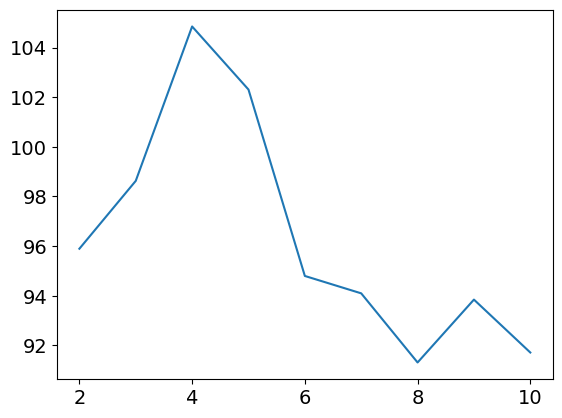

In [32]:
bestK = -99
bestSigSum = -99
signifSums = {}
# Don't bother counting low significances:
minSignif = 1
# Don't bother with things we have obviously excluded.
maxSignif = 5

for k in sorted(bestSignifs.keys()):
    signifSums[k] = sum([signif for signif in bestSignifs[k].values() if signif > minSignif and signif < maxSignif])
    # We don't want redundant clusters
    nBestClusters = len(list(set(bestClusters[k].values())))
    if signifSums[k] > bestSigSum:# and nBestClusters == k-1:
        bestSigSum = signifSums[k]
        bestK = k

fig, ax = plt.subplots()
plt.plot(sorted(bestSignifs.keys()), [signifSums[k] for k in sorted(bestSignifs.keys())])
print(bestK)

In [33]:
# Now get the cluster labels for the raw data
Kmean = KMeans(n_clusters=bestK, random_state=randomState)
#Kmean.fit(clusteringData)
Kmean.fit(clusteringData[trainBranches], sample_weight=rawDataPresel.clus_weight)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_

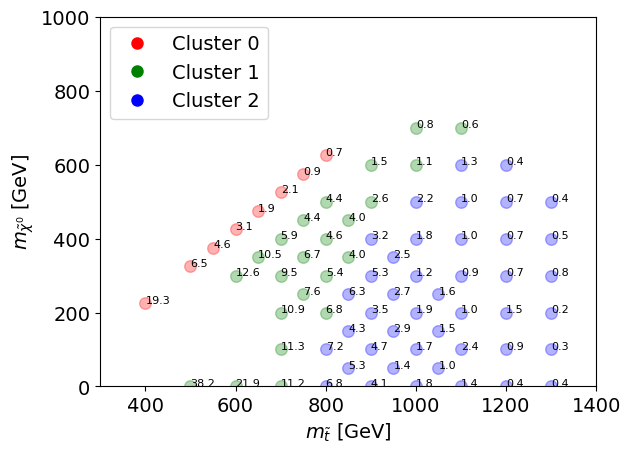

In [34]:
colors = ['r', 'g', 'b', 'y', 'c', 'k', 'm', 'tab:orange', 'tab:brown']
fig, ax = plt.subplots()
stopMasses = []
lspMasses = []
significances = {}
signifList = []
for sampLabel in sampLabels:
    if sampLabel == 'bkg':
        continue
    stopMasses.append(stopLSPMasses[sampLabel][0])
    lspMasses.append(stopLSPMasses[sampLabel][1])
    significances[(stopLSPMasses[sampLabel][0], stopLSPMasses[sampLabel][1])] = bestSignifs[k][sampLabel]
    signifList.append(bestSignifs[k][sampLabel])
    plt.scatter([stopLSPMasses[sampLabel][0]], [stopLSPMasses[sampLabel][1]], c=colors[bestClusters[bestK][sampLabel]], label=f'Cluster {bestClusters[bestK][sampLabel]}', alpha=0.3, s=70)
    ax.annotate(f'{round(bestSignifs[k][sampLabel],1)}', stopLSPMasses[sampLabel], fontsize=8)
ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1400)
ax.set_ylim(0,1000)
handles, labels = plt.gca().get_legend_handles_labels()
sortedLabels = sorted(list(set(labels)))
legHandles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colors[clusI], markersize=10) for clusI in range(bestK)]
plt.legend(ncol=1, handles=legHandles, labels=sortedLabels, loc='upper left')
plt.savefig(f"grid_postclustering_{varListStr}_signif.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_{varListStr}_signif.pdf",bbox_inches='tight')

(74, 74) (74, 74) (74, 74)
74 74


<ipython-input-35-cd891e12b417>:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  my_cmap.set_under('w',.1)


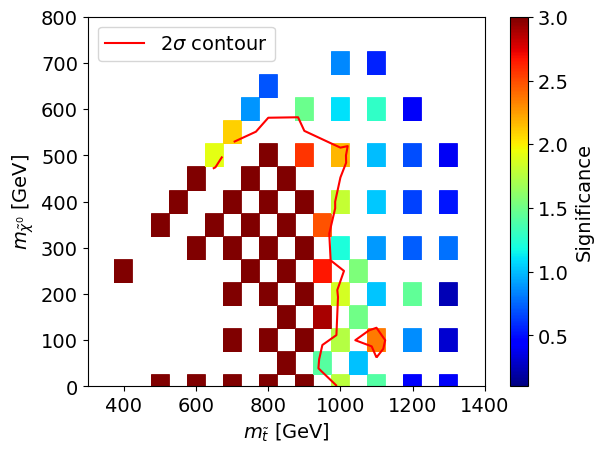

In [35]:
X, Y = np.meshgrid(stopMasses, lspMasses)
Z = np.ndarray((len(stopMasses), len(lspMasses)))
print(X.shape, Y.shape, Z.shape)
print(len(stopMasses), len(lspMasses))
for xi in range(len(stopMasses)):
    for yi in range(len(lspMasses)):
        stopMass = stopMasses[xi]
        lspMass = lspMasses[yi]
        if (stopMass, lspMass) in significances:
            Z[xi][yi] = significances[(stopMass, lspMass)]
        else:
            Z[xi][yi] = np.nan
#print(Z[0,1], stopMasses[0], lspMasses[1], significances[(stopMasses[0], lspMasses[1])])
fig, ax = plt.subplots()
my_cmap = plt.cm.jet
my_cmap.set_under('w',.1)
bins2d = [np.array([375+i*50 for i in range(21)]), np.array([-25+i*50 for i in range(21)])]
h2 = plt.hist2d(stopMasses, lspMasses, bins=bins2d, weights=signifList, vmin=0.1, vmax=3, cmap=my_cmap)
cb = plt.colorbar(h2[3])
cb.set_label('Significance')
plt.tricontour(stopMasses, lspMasses, signifList, levels=[2], colors='r')

ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1400)
ax.set_ylim(0,800)
legHandles = [matplotlib.lines.Line2D(range(1), range(1), color="r", marker='o', markerfacecolor='w', markersize=0) ]

plt.legend(handles=legHandles, loc='upper left', labels=['2$\sigma$ contour'])

plt.savefig(f"grid_contour_{varListStr}_signif.svg",bbox_inches='tight')
plt.savefig(f"grid_contour_{varListStr}_signif.pdf",bbox_inches='tight')
